# Characterizing WTSN channels

This notebooks simulates a basic WTSN system with some UEs, an access point and 
some base schedules to determine what the packet latencies and throughput are under 
different conditions.

In [104]:
# Necessary imports

from enum import Enum
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import typing
from typing import List, Tuple, Dict

In [138]:
# Create the necessary classes and structures

# TODO: do you need a mapping between the parameters of the sheet and corresponding latency?
# TODO: Add functions to plot the base schedules and whatnot

class PacketStatus(Enum):
    '''
    Enum to represent the status of a packet
    '''
    ARRIVED = 1
    QUEUED = 2
    DELIVERED = 3
    DROPPED = 4

class Packet:
    '''
    Class to represent a packet in the Wi-Fi network
    '''

    def __init__(self, size: int, priority: int, sequence_number: int, arrival_time: float) -> None:
        '''
        Constructor for the packet class

        Args:
            size (int): Size of the packet in bytes
            priority (int): Priority of the packet, the higher the value, higher
                the priority
            arrival_time (float): Time at which the packet arrives at the UE's 
                link layer for transmission in microseconds
        ''' 
        self.size = size
        self.priority = priority
        self.sequence_number = sequence_number
        self.arrival_time = arrival_time
        self.delivery_time = None
        self.status = PacketStatus.ARRIVED

    # Implement a __str__ function to print the packet
    def __str__(self) -> str:
        '''
        Function to print the packet
        '''
        output = (f"Packet(Size: {self.size} bytes, "
            f"Priority: {self.priority}, "
            f"Sequence Number: {self.sequence_number}, "
            f"Arrival Time: {self.arrival_time} microseconds), "
            f"Delivery Time: {self.delivery_time} microseconds), "
            f"Status: {self.status.name}")

        return output
        



class Slot:
    '''
    Class to represent a slot in the Wi-Fi network. This corresponds to a Qbv window
    and can either be reserved for a UE or have contetion
    '''
    
    def __init__(self, slot_index: int, start_time: float, end_time: float, mode: str, 
                UEs: List[str]) -> None:
        '''
        Constructor for the Slot class

        Args:
            slot_index (int): Index of the slot in the schedule, starts from 0
            start_time (float): Start time of the slot in microseconds
            end_time (float): End time of the slot in microseconds
            mode (str): Mode of the slot, can be either contention or reserved (using Qbv)
            UEs (List[str]): List of UEs that are permitted to transmit in the slot
        '''
        self.slot_index = slot_index
        self.start_time = start_time
        self.end_time = end_time
        self.mode = mode
        self.UEs = UEs

    # Implement a __str__ function to print the slot
    def __str__(self) -> str:
        '''
        Function to print the slot
        '''
        return (f"Slot(Index: {self.slot_index}, "
            f"Start Time: {self.start_time} microseconds, "
            f"End Time: {self.end_time} microseconds, "
            f"Mode: {self.mode}, "
            f"UEs: {self.UEs})")

class Schedule:
    '''
    Class to represent the base schedule for the Wi-Fi network
    '''

    def __init__(self, start_time: float, end_time: float, num_slots: int, 
                 schedule: typing.Dict[int, Slot]) -> None:
        '''
        Constructor for the BaseSchedule class

        Args:
            start_time (float): Start time of the schedule in microseconds
            end_time (float): End time of the schedule in microseconds
            num_slots (int): Number of slots in the schedule
            schedule (typing.Dict[int, typing.Dict[int, int]]): A dictionary with 
                the priority as the key and another dictionary as the value. This
                inner dictionary has the sequence number as the key and the size
                of the packet as the value
        '''
        self.start_time = start_time
        self.end_time = end_time
        self.num_slots = num_slots
        self.schedule = schedule

    # Implement a __str__ function to print the schedule   
    def __str__(self) -> str:
        '''
        Function to print the schedule
        '''
        output = (f"Schedule(Start Time: {self.start_time} microseconds, "
            f"End Time: {self.end_time} microseconds, "
            f"Number of Slots: {self.num_slots})")
        output += "\nSlots: \n"
        for slot in self.schedule:
            output += "\t" + str(self.schedule[slot]) + "\n"
        return output

class UE:
    '''
    Class to represent a User Equipment (UE) or STA in the Wi-Fi network
    '''
    # TODO: evaluate use of MCS
    # TODO: make MCS a function of not just priority but also time or slot index
    # TODO: write setting functions for each parameter
    # TODO: consider making this a super class with AP and STA as subclasses
    # TODO: consider adding both uplink and downlink functionality- is it even different
    def __init__(self, ue_id: int, mcs: typing.Dict[int, int], network_mode_of_operation: str, 
                service_mode_of_operation: str, n_packets : int) -> None:
        '''
        Constructor for the UE class

        Args:
            mcs (typing.Dict[int, int]): Dictionary with the priority as the key
                and the MCS as the value i.e packets with the priority will 
                be transmitted at the corresponding MCS
            netowork_mode_of_operation (str): Mode of operation of the UE, can be either
                "central control" or "free" (TODO: add more modes)
            service_mode_of_operation (str): Mode of operation of the UE within a Qbv
                window, used to determine how TXOP is used, how packets are allocated etc.
            n_packets (int): Number of packets that the UE has to transmit
        '''
        self.ue_id = ue_id
        self.mcs = mcs
        # TODO: remove these modes of operation and feed them into functions instead
        self.network_mode_of_operation = network_mode_of_operation
        self.service_mode_of_operation = service_mode_of_operation
        self.n_packets = n_packets
        # List to store the packets that the UE has to transmit
        self.packets = []

    def __str__(self) -> str:
        '''
        Function to print the UE
        '''
        output = (f"UE(UE ID: {self.ue_id}, "
            f"UE(MCS: {self.mcs}, "
            f"Network mode of Operation: {self.network_mode_of_operation}, "
            f"Service mode of Operation: {self.service_mode_of_operation}, "
            f"Number of Packets: {self.n_packets})")
        output += "\nPackets: \n"
        for packet in self.packets:
            output += "\t" + str(packet) + "\n"
        return output
        


    def  generate_packets(self, base_schedule : Schedule, packet_size: List[int], 
                          packet_priorities: List[int]) ->  None:
        '''
        TODO: Fix this to take a custom generator function from outside and run that,
            this function can potentially enforce some constraints on the custom funciton that 
            is passed in 
        Function to generate the packets that the UE has to transmit

        Args:
            base_schedule (Schedule): A base schedule specifying
                Qbv windows for different UEs across time
            packet_size (List[int]): size of each packet
        '''

        if self.network_mode_of_operation == "central control":

            assert len(packet_size) == self.n_packets, "Number of packet sizes and number \
                                                        of packets don't match"
            assert len(packet_priorities) == self.n_packets, "Number of priorities and number of \
                                                    packets don't match"

            ue_name = "UE" + str(self.ue_id)
            num_slots_ue = 0
            slots_ue = []
            for slot in base_schedule.schedule:
                if ue_name in base_schedule.schedule[slot].UEs:
                    num_slots_ue += 1
                    slots_ue.append(base_schedule.schedule[slot].slot_index)
            
            # Generate packets based on the schedule
            # TODO: Fix the case where n_packets is lesser than number of slots allocated
            assert self.n_packets >= num_slots_ue, "Number of packets is lesser than the number of slots allocated"
            num_packets_per_slot = [int(np.floor(self.n_packets/num_slots_ue))]*num_slots_ue
            # If the number of packets isn't divisible by the number of slots
            # then put the remaining packets in the last slot
            num_packets_per_slot[-1] += self.n_packets - sum(num_packets_per_slot)

            assert len(slots_ue) == len(num_packets_per_slot), "Number of slots and number of \
                                                                packets per slot don't match"

            packet_counter = 0
            for slot_index, num_packets in zip(slots_ue, num_packets_per_slot):
                for _ in range(num_packets):
                    self.packets.append(Packet(size=packet_size[packet_counter], 
                                                priority= packet_priorities[packet_counter], 
                                                sequence_number=packet_counter,
                                                arrival_time=base_schedule.schedule[slot_index].start_time - 1))
                    packet_counter += 1

    def obtain_packet_latency(self) -> List[float]:
        '''
        Function to obtain the latency of each packet

        Returns:
            List[float]: List of latencies of each packet
        '''
        latencies = []
        for packet in self.packets:
            if packet.status == PacketStatus.DELIVERED:
                latencies.append(packet.delivery_time - packet.arrival_time)
            else:
                latencies.append(None)
        return latencies
            
    def serve_packets(self, base_schedule: Schedule, **kwargs) -> None:
        # TODO: Move this function to the network class
        '''
        Function to serve the packets that the UE has to transmit

        Args:
            base_schedule (Schedule): A base schedule specifying
                Qbv windows for different UEs across time
        '''
        if self.service_mode_of_operation == "Mode 1":
            '''
            Mode 1: Dummy mode for testing 

            Simply marks all packets as served after a 3000 microsecond delay
            '''

            for packet in self.packets:
                packet.delivery_time = packet.arrival_time + 3000
                packet.status = PacketStatus.DELIVERED
        
        elif self.service_mode_of_operation == "Mode 2":
            '''
            Mode 2: Mode for testing with a single Qbv window based on packet limits
                i.e only so many bytes can be served in a single Qbv window. The 
                number of packets that fit this number of bytes are served and the 
                rest are queued to be served in the next Qbv window
            '''
            # Need allowed payload size
            # Need latency with allowed payload size
            # how does it handle MCS?
            assert 'payload_size' in kwargs, "Payload size not provided"
            assert 'delivery_latency' in kwargs, "Delivery latency not provided"
            
            UE_name = "UE" + str(self.ue_id)


            payload_size = kwargs['payload_size']
            delivery_latency = kwargs['delivery_latency']
            for slot in base_schedule.schedule:
                if UE_name in base_schedule.schedule[slot].UEs:
                    # Get the packets that can be served in this slot
                    payload_used = 0
                    for packet in self.packets: # Relying on this being ordered by sequence number
                        if packet.arrival_time <= base_schedule.schedule[slot].start_time:
                            if packet.status == PacketStatus.ARRIVED or packet.status == PacketStatus.QUEUED:
                                if payload_used + packet.size <= payload_size:
                                    packet.delivery_time = base_schedule.schedule[slot].start_time + delivery_latency
                                    packet.status = PacketStatus.DELIVERED
                                    payload_used += packet.size
                                else:
                                    packet.status = PacketStatus.QUEUED
            

                        






# TODO: Write a network class

## Dummy simulation

Dummy simulation that marks all packets as delivered after a small wait time. Used
to test that all classes are functioning as they should.

In [139]:
# Create a schedule with 2 slots and 2 UEs
slot1 = Slot(0, 0, 10000, "reserved", ["UE0"])
slot2 = Slot(1, 10000, 20000, "reserved", ["UE0"])
schedule = {0: slot1, 1: slot2}
base_schedule = Schedule(0, 20000, 2, schedule)
print(base_schedule)

# Create a UE
ue = UE(0,{1: 0, 2: 1}, "central control", "Mode 1",  10)
ue.generate_packets(base_schedule, [100]*10, [1]*10)
print(ue)

# Serve the packets
ue.serve_packets(base_schedule)
print(ue)

latencies = ue.obtain_packet_latency()
print(latencies)

Schedule(Start Time: 0 microseconds, End Time: 20000 microseconds, Number of Slots: 2)
Slots: 
	Slot(Index: 0, Start Time: 0 microseconds, End Time: 10000 microseconds, Mode: reserved, UEs: ['UE0'])
	Slot(Index: 1, Start Time: 10000 microseconds, End Time: 20000 microseconds, Mode: reserved, UEs: ['UE0'])

UE(UE ID: 0, UE(MCS: {1: 0, 2: 1}, Network mode of Operation: central control, Service mode of Operation: Mode 1, Number of Packets: 10)
Packets: 
	Packet(Size: 100 bytes, Priority: 1, Sequence Number: 0, Arrival Time: -1 microseconds), Delivery Time: None microseconds), Status: ARRIVED
	Packet(Size: 100 bytes, Priority: 1, Sequence Number: 1, Arrival Time: -1 microseconds), Delivery Time: None microseconds), Status: ARRIVED
	Packet(Size: 100 bytes, Priority: 1, Sequence Number: 2, Arrival Time: -1 microseconds), Delivery Time: None microseconds), Status: ARRIVED
	Packet(Size: 100 bytes, Priority: 1, Sequence Number: 3, Arrival Time: -1 microseconds), Delivery Time: None microseconds

## Simulation of a UE with periodic slots 

- The base schedule is  
  - t0 - t1: UE 1
  - t1 - t2: UE 2
  - t2 - t3: UE 3
  - t3 - t4: UE 1 and repeat
- Packets are perfectly synchronized with the 

UE(UE ID: 0, UE(MCS: {1: 0, 2: 1}, Network mode of Operation: central control, Service mode of Operation: Mode 2, Number of Packets: 1100)
Packets: 
	Packet(Size: 100 bytes, Priority: 1, Sequence Number: 0, Arrival Time: 9 microseconds), Delivery Time: 5010 microseconds), Status: DELIVERED
	Packet(Size: 100 bytes, Priority: 1, Sequence Number: 1, Arrival Time: 9 microseconds), Delivery Time: 5010 microseconds), Status: DELIVERED
	Packet(Size: 100 bytes, Priority: 1, Sequence Number: 2, Arrival Time: 9 microseconds), Delivery Time: 5010 microseconds), Status: DELIVERED
	Packet(Size: 100 bytes, Priority: 1, Sequence Number: 3, Arrival Time: 9 microseconds), Delivery Time: 5010 microseconds), Status: DELIVERED
	Packet(Size: 100 bytes, Priority: 1, Sequence Number: 4, Arrival Time: 9 microseconds), Delivery Time: 5010 microseconds), Status: DELIVERED
	Packet(Size: 100 bytes, Priority: 1, Sequence Number: 5, Arrival Time: 9 microseconds), Delivery Time: 5010 microseconds), Status: DELIVERED

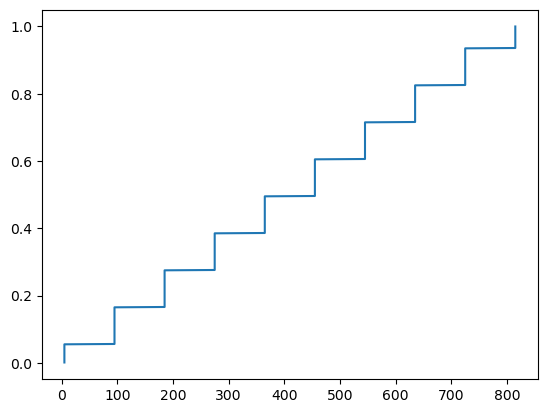

In [140]:
num_UEs = 3
UEs = ["UE" + str(i) for i in range(num_UEs)]
num_packets_per_ue = 1100  # Number of packets per UE for the whole period

## Schedule parameters
num_slots_per_UE = 100
num_slots = num_slots_per_UE*num_UEs
start_offset = 10 # microseconds
end_time = start_offset
slot_duration = 30000 # microseconds
slots = {}


# packet and payload sizes
packet_sizes = [100]*num_packets_per_ue
priorities = [1]*num_packets_per_ue
payload_size=1000
delivery_latency=5000

# TODO: move the knowledge of how many packets there are to this part of the code
# instead of keeping it in the UE class

# Create a schedule
start_time = start_offset
for i in range(num_slots):
    slots[i] = Slot(i, start_time, start_time + slot_duration, "reserved", [UEs[i%num_UEs]])
    start_time += slot_duration
schedule = Schedule(start_offset, start_time, num_slots, slots)

# print(schedule)


# Create UEs and packets
UEs = {}
for i in range(num_UEs):
    UE_temp = UE(i, {1: 0, 2: 1}, "central control", "Mode 2",  num_packets_per_ue)
    UE_temp.generate_packets(schedule, packet_sizes, priorities)
    UEs[i] = UE_temp

# for i in UEs:
#     print(UEs[i])

# Serve the packets
for i in UEs:
    UEs[i].serve_packets(schedule, payload_size=payload_size, delivery_latency=delivery_latency)

print(UEs[0])

latencies = UEs[0].obtain_packet_latency()
print(latencies)
latencies = [latency for latency in latencies if latency is not None]
# Plot a cdf of the latencies using the latencies variable above
latencies = np.array(latencies)
latencies = latencies/1000 # convert to milliseconds
latencies = np.sort(latencies)
yvals = (np.arange(len(latencies)) + 1)/float(len(latencies))
plt.plot(latencies, yvals)

[  1   1   2   2   6   6   7   9   9  10  10  14  15  15  16  16  18  21
  21  22  22  23  23  26  27  27  27  31  32  34  34  37  38  41  43  44
  45  45  45  45  46  46  49  49  49  53  54  54  55  59  60  62  62  62
  63  67  67  70  70  72  72  72  73  74  75  75  76  77  77  77  77  79
  80  80  85  85  88  88  92  92  93  93  93  95  95  96  97  98  98  99
  99 100 102 102 103 103 105 107 107 107 107 108 111 112 113 114 115 116
 117 117 119 120 120 121 122 123 124 124 124 125 129 130 130 131 132 132
 132 134 134 135 136 137 137 139 139 142 143 143 144 144 145 146 147 147
 147 147 149 149 149 150 152 153 153 154 155 156 156 160 160 161 161 163
 163 163 165 165 165 165 166 170 170 172 172 172 173 175 175 177 180 181
 181 182 182 182 184 187 189 189 189 192 192 193 194 195 196 196 197 198
 198 199 199 204 204 204 206 208 208 209 210 210 212 213 213 216 217 217
 220 221 221 222 223 223 224 225 227 229 234 236 238 239 239 240 241 241
 242 243 243 244 245 245 247 247 249 249 251 252 25

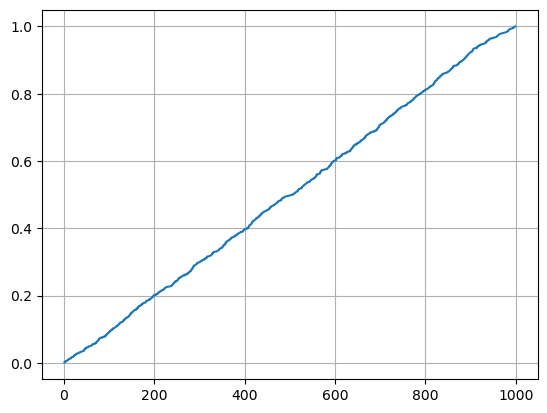

In [124]:
# generate thousand random numbers between 1 and 1000
latencies = np.random.randint(1, 1000, 1000)

latencies = np.array(latencies)
# latencies = latencies/1000 # convert to milliseconds
latencies = np.sort(latencies)
yvals = (np.arange(len(latencies))+ 1)/float(len(latencies))
print(latencies)
print(yvals)
plt.plot(latencies, yvals)
plt.grid()